In [88]:
import pdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import graphviz
import pickle
import joblib
from collections import Counter
from datetime import datetime
# from fancyimpute import SoftImpute, BiScaler
import softimpute_als


## Read augmented data dictionary 

In [114]:
# Data dictionary has spaces in column names, remove those
df_pad = pd.read_csv("./data/property-assessments-data-dictionary.csv", encoding = "ISO-8859-1")
df_pad.rename(columns = {c: c.replace(' ', '') for c in df_pad.columns}, inplace = True)
df_pad.head(3)

,FieldName,DataTypeandLength,FieldDescription,Example1,Example2,handle,AdditionalDataDetails,Unnamed:7
0,PARID,A30,Parcel Identification Number,0023S00162000000,1468J00244000000,key,A 16 character unique identifier for the parcel.,NaN
1,PROPERTYHOUSENUM,NBR(10),Property Location House Number,514,69,meta,House Number for the physical location of pro...,may be zero or blank.
2,PROPERTYFRACTION,A6,Property Location House Number Fraction,NaN,-73,meta,Continued House Number information for the ph...,NaN


## Read assessment data

In [115]:
# Use data dictionary types to convert numbers make everything else a string
dt = {c.FieldName: (float if c.DataTypeandLength.lower().startswith('n') else str) for c in df_pad.itertuples()}
df_asm = pd.read_csv("./data/assessments.csv", dtype=dt)
print(df_asm.shape)
with pd.option_context('display.max_rows', 100, 'display.max_columns', 100):
    display(df_asm.head(1))

(580989, 95)


,PARID,PROPERTYHOUSENUM,PROPERTYFRACTION,PROPERTYADDRESS,PROPERTYCITY,PROPERTYSTATE,PROPERTYUNIT,PROPERTYZIP,MUNICODE,MUNIDESC,SCHOOLCODE,SCHOOLDESC,LEGAL1,LEGAL2,LEGAL3,NEIGHCODE,NEIGHDESC,TAXCODE,TAXDESC,TAXSUBCODE,TAXSUBCODE_DESC,OWNERCODE,OWNERDESC,CLASS,CLASSDESC,USECODE,USEDESC,LOTAREA,HOMESTEADFLAG,CLEANGREEN,FARMSTEADFLAG,ABATEMENTFLAG,RECORDDATE,SALEDATE,SALEPRICE,SALECODE,SALEDESC,DEEDBOOK,DEEDPAGE,PREVSALEDATE,PREVSALEPRICE,PREVSALEDATE2,PREVSALEPRICE2,CHANGENOTICEADDRESS1,CHANGENOTICEADDRESS2,CHANGENOTICEADDRESS3,CHANGENOTICEADDRESS4,COUNTYBUILDING,COUNTYLAND,COUNTYTOTAL,COUNTYEXEMPTBLDG,LOCALBUILDING,LOCALLAND,LOCALTOTAL,FAIRMARKETBUILDING,FAIRMARKETLAND,FAIRMARKETTOTAL,STYLE,STYLEDESC,STORIES,YEARBLT,EXTERIORFINISH,EXTFINISH_DESC,ROOF,ROOFDESC,BASEMENT,BASEMENTDESC,GRADE,GRADEDESC,CONDITION,CONDITIONDESC,CDU,CDUDESC,TOTALROOMS,BEDROOMS,FULLBATHS,HALFBATHS,HEATINGCOOLING,HEATINGCOOLINGDESC,FIREPLACES,BSMTGARAGE,FINISHEDLIVINGAREA,CARDNUMBER,ALT_ID,TAXYEAR,ASOFDATE,MUNICIPALITY,NEIGHBORHOOD,PGH_COUNCIL_DISTRICT,PGH_WARD,PGH_PUBLIC_WORKS_DIVISION,PGH_POLICE_ZONE,PGH_FIRE_ZONE,TRACT,BLOCK_GROUP
0,0001G00204000000,135.0,,1ST AVE,PITTSBURGH,PA,,15222,101,1st Ward - PITTSBURGH,47,Pittsburgh,LOT 35.12X100,NaN,NaN,51C02,PITTSBURGH URBAN,T,20 - Taxable,NaN,NaN,20,CORPORATION,NaN,COMMERCIAL,447,OFFICE - 1-2 STORIES,7000.0,NaN,NaN,NaN,NaN,NaN,02-03-1993,333000.0,0,VALID SALE,8901,458,NaN,NaN,NaN,NaN,111 BLVD OF THE ALLIES,,PITTSBURGH PA,15222,233100.0,280000.0,513100.0,0.0,233100.0,280000.0,513100.0,233100.0,280000.0,513100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2021.0,2021-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [117]:
# Extract single family homes
df_asm = df_asm[(df_asm.CLASSDESC == 'RESIDENTIAL') & (df_asm.USEDESC == 'SINGLE FAMILY')].copy()
df_asm.reset_index(drop = True, inplace = True)
# Delete the county assessment (keeping LOCAL)
del df_asm['COUNTYBUILDING']
del df_asm['COUNTYLAND']
del df_asm['COUNTYTOTAL']
df_asm.shape

(373244, 92)

## Extract and combine

In [118]:
def f_order(x, k):
    """
    Encode the levels of x to k-levels according to frequency.
    :param x: Initial variable with many levels.
    :param k: Number of levels to produce.
    :return: Output variable with k levels.
    """
    # Target level size
    m = (len(x) // k) + 1
    # Level map {x-level: k-level}
    lmap = {}
    # Accumulator, new label
    acc, lbl = 0, None
    for c in Counter(x).most_common():
        if acc + c[1] > m:
            lbl = 1 if lbl is None else (lbl+1)
            acc = c[1]
        else:
            acc += c[1]
        lmap[c[0]] = lbl
    return np.array([lmap[v] for v in x])

def n_range(x):
    """
    Rescale the numerical series x to [0, 1] via rank, map NaN to -1.
    :param x: Numerical series 
    :return: rank(x) / len(x)  (NaN = -1)
    """
    y = np.argsort(np.argsort(x)) / len(x)
    y[np.isnan(x)] = -1
    return y


### One-hot columns

In [119]:
# Count uniques in one-hot candidates
for r in df_pad.itertuples():
    if r.handle == 'oh':
        print((r.FieldName, df_asm[r.FieldName].nunique()))       

('MUNICODE', 173)
('SCHOOLCODE', 46)
('NEIGHCODE', 457)
('TAXCODE', 2)
('TAXSUBCODE', 1)
('OWNERCODE', 10)
('CLASS', 0)
('USECODE', 1)
('SALECODE', 72)
('STYLE', 25)
('EXTERIORFINISH', 8)
('ROOF', 6)
('BASEMENT', 5)
('GRADE', 21)
('CONDITION', 8)
('CDU', 8)
('HEATINGCOOLING', 16)
('BSMTGARAGE', 7)


In [120]:
# Check distribution of high-count columns
# Counter(df_asm.MUNICODE).most_common() 
# Counter(df_asm.SCHOOLCODE).most_common()
# Counter(df_asm.NEIGHCODE).most_common(150)
# ...
noh = 10
nmn = 3
nmx = 100
ohc = []
for c in df_pad[df_pad.handle == 'oh'].FieldName:
    n = df_asm[c].nunique()
    if n < nmn or n > nmx: continue
    if n < noh:
        ohc.append(pd.get_dummies(df_asm[c], prefix = c + '_O', dummy_na = True))
    else:
        ohc.append(pd.get_dummies(f_order(df_asm[c], noh), prefix = c + '_K', dummy_na = False))
df_ohc = pd.concat(ohc, axis = 1)
print(df_ohc.shape)
df_ohc.head()

(373244, 87)


,SCHOOLCODE_K_1,SCHOOLCODE_K_2,SCHOOLCODE_K_3,SCHOOLCODE_K_4,SCHOOLCODE_K_5,SCHOOLCODE_K_6,SCHOOLCODE_K_7,SCHOOLCODE_K_8,SCHOOLCODE_K_9,SCHOOLCODE_K_10,...,HEATINGCOOLING_K_2,HEATINGCOOLING_K_3,BSMTGARAGE_O_0,BSMTGARAGE_O_1,BSMTGARAGE_O_2,BSMTGARAGE_O_3,BSMTGARAGE_O_4,BSMTGARAGE_O_5,BSMTGARAGE_O_6,BSMTGARAGE_O_nan
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,1,0,1,0,0,0,0,0,0,0


### Date columns

In [121]:
dd = {}
for c in df_pad[df_pad.handle == 'date'].FieldName:
    d = df_asm[c].str[6:].astype(float) + df_asm[c].str[:2].astype(float) / 13
    dd[c + '_D'] = n_range(d)
df_dat = pd.DataFrame(dd)
df_dat.head()

,SALEDATE_D,PREVSALEDATE_D,PREVSALEDATE2_D
0,0.643780,0.499997,-1.000000
1,0.860836,0.473283,0.578222
2,0.839073,-1.000000,-1.000000
3,0.243096,0.473296,-1.000000
4,0.454914,0.473299,0.578236


### Numeric columns

In [122]:
nd = {}
for c in df_pad[df_pad.handle == 'num'].FieldName:
    if c in df_asm:
        nd[c + '_N'] = n_range(df_asm[c].astype(float))
df_num = pd.DataFrame(nd)
df_num.head()

,LOTAREA_N,SALEPRICE_N,PREVSALEPRICE_N,PREVSALEPRICE2_N,COUNTYEXEMPTBLDG_N,LOCALBUILDING_N,LOCALLAND_N,LOCALTOTAL_N,FAIRMARKETBUILDING_N,FAIRMARKETLAND_N,FAIRMARKETTOTAL_N,STORIES_N,YEARBLT_N,TOTALROOMS_N,BEDROOMS_N,FULLBATHS_N,HALFBATHS_N,FIREPLACES_N,FINISHEDLIVINGAREA_N
0,0.003344,0.991282,0.499997,-1.000000,0.000000,0.999652,0.980168,0.999553,0.999652,0.979745,0.999539,0.107769,0.357163,0.260133,0.234276,0.068789,0.936417,-1.000000,0.092417
1,0.005565,0.889994,0.473575,0.578362,0.666668,0.999566,0.629907,0.999287,0.999566,0.628902,0.999277,0.644477,0.367711,0.000865,0.528882,0.318090,0.737831,-1.000000,0.838162
2,0.012774,0.322513,-1.000000,-1.000000,0.666666,0.999301,0.992571,0.999215,0.999301,0.992292,0.999207,0.630826,0.076079,0.141136,0.015298,0.322232,0.737491,-1.000000,0.864799
3,0.002269,0.824838,0.473580,-1.000000,0.666663,0.100417,0.052529,0.068309,0.100449,0.052472,0.068462,0.613387,0.711610,0.136589,0.539695,0.001007,0.737338,0.575455,0.001007
4,0.011633,0.002125,0.473586,0.578370,0.666660,0.150813,0.058610,0.104168,0.151145,0.058203,0.103822,0.107897,0.289768,0.546905,0.546905,0.326095,0.737097,0.575565,0.513211


### Binary columns

In [123]:
for c in df_pad[df_pad.handle == 'bin'].FieldName: 
    print((c, Counter(df_asm[c])))

df_bin = pd.DataFrame({'HOMESTEADFLAG_B': np.where(df_asm.HOMESTEADFLAG.isna(), -1, 1)})


('HOMESTEADFLAG', Counter({'HOM': 268269, nan: 104975}))
('CLEANGREEN', Counter({nan: 372803, 'Y': 441}))
('FARMSTEADFLAG', Counter({nan: 373241, 'FRM': 3}))
('ABATEMENTFLAG', Counter({nan: 373233, 'Y': 11}))


### Combine

In [124]:
df_dat = pd.concat([df_num, df_dat, df_ohc, df_bin], axis = 1)

In [125]:
with open('df_dat.pkl', 'wb') as p:
    pickle.dump(df_dat, p)
df_dat.shape

(373244, 110)

## Impute sample

In [126]:
m = 0.2
Y = df_dat.values
X = Y.copy()
# Randomly set nan values in each column
for c in range(X.shape[1]):
    X[np.random.randint(0, len(df_dat), int(m * len(df_dat))), c] = float('nan')

In [85]:
# Not helpful
#Y = BiScaler(scale_rows=False, scale_columns=False, verbose = False).fit_transform(df_X.values)
#X = Y.copy()
#for c in range(X.shape[1]):
#    X[np.random.randint(0, len(df_dat), int(m * len(df_dat))), c] = float('nan')

In [127]:
print(datetime.now())
Z1 = softimpute_als.SoftImpute(J = 20).fit(X).predict(X)
print(datetime.now())

2021-04-07 02:26:36.062799
2021-04-07 02:27:43.977192


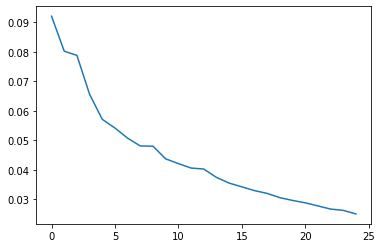

In [95]:
# Choose a reasonable cutoff for rank
err = []
for j in range(20,25):
    print(j)
    Z = softimpute_als.SoftImpute(J = j).fit(X).predict(X)
    err.append(np.mean(np.mean((Y - Z)**2)))

plt.plot(err)

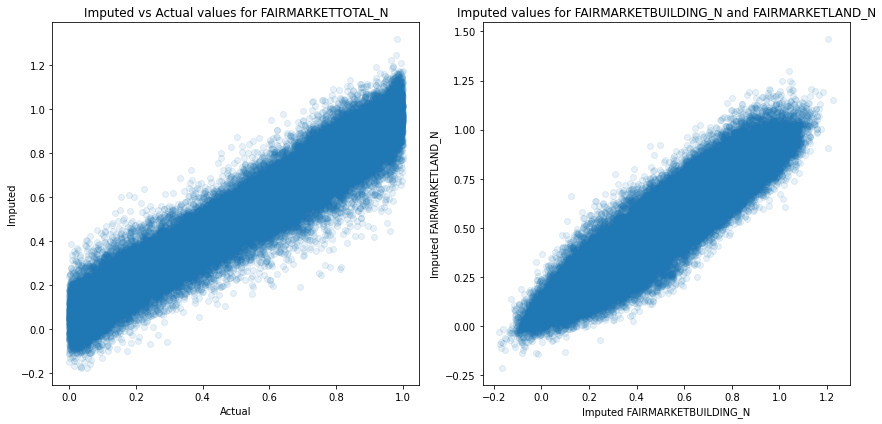

In [128]:
fig, ax = plt.subplots(1,2, figsize = (12, 6))

ax[0].scatter(Y[np.isnan(X[:,10]),10], Z1[np.isnan(X[:,10]),10], alpha = 0.1)
ax[0].set_title(f"Imputed vs Actual values for {df_dat.columns[10]}")
ax[0].set_xlabel(f"Actual")
ax[0].set_ylabel(f"Imputed")

ax[1].scatter(Z1[np.isnan(X[:,10]),8], Z1[np.isnan(X[:,10]),9], alpha = 0.1)
ax[1].set_title(f"Imputed values for {df_dat.columns[8]} and {df_dat.columns[9]}")
ax[1].set_xlabel(f"Imputed {df_dat.columns[8]}")
ax[1].set_ylabel(f"Imputed {df_dat.columns[9]}")

plt.tight_layout()

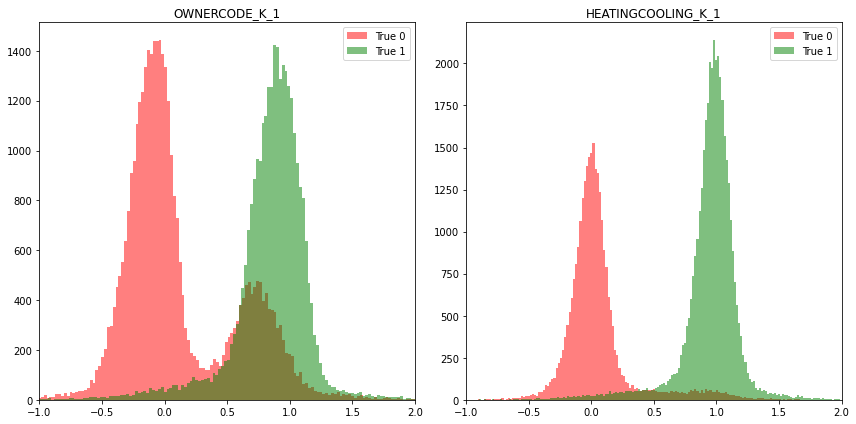

In [129]:
fig, ax = plt.subplots(1,2, figsize = (12, 6))
c1 = 'OWNERCODE_K_1'
i1 = df_dat.columns.to_list().index(c1)
y1 = Y[np.isnan(X[:,i1]), i1]
z1 = Z1[np.isnan(X[:,i1]), i1]

c2 = 'HEATINGCOOLING_K_1'
i2 = df_dat.columns.to_list().index(c2)
y2 = Y[np.isnan(X[:,i2]),i2]
z2 = Z1[np.isnan(X[:,i2]),i2]

ax[0].hist(z1[y1 == 0.0], 200, color = 'r', alpha = 0.5, label = 'True 0');
ax[0].hist(z1[y1 == 1.0], 200, color = 'g', alpha = 0.5, label = 'True 1');
ax[0].set_xlim((-1,2))
ax[0].set_title(f"{c1}")
ax[0].legend()

ax[1].hist(z2[y2 == 0.0], 200, color = 'r', alpha = 0.5, label = 'True 0');
ax[1].hist(z2[y2 == 1.0], 200, color = 'g', alpha = 0.5, label = 'True 1');
ax[1].set_xlim((-1,2))
ax[1].set_title(f"{c2}")
ax[1].legend()
plt.tight_layout()

## Anomaly Detection

In [ ]:
# Generate n-cycles of imputation over m-fraction of data
np.random.seed(543)
n, m = 100, 0.2
E, N = None, None
for i in range(n):
    # Worry line
    print((i, datetime.now()))
    # Copy data array
    X = df_dat.values.copy()
    # Randomly set nan values in each column
    for c in range(X.shape[1]):
        X[np.random.randint(0, len(df_dat), int(m * len(df_dat))), c] = float('nan')
    # Impute nan
    Y = softimpute_als.SoftImpute(J = 20).fit(X).predict(X)
    # Pickle result
    with open(f"./imputations/imp_{i}.pkl", 'wb') as p:
        joblib.dump({'X': X, 'Y': Y}, p, compress='zlib')
    # Initialize E, N
    if E is None:
        E = np.zeros(X.shape)
        N = np.zeros(X.shape)
    # Keep sign of error
    E[np.isnan(X)] += (df_dat.values[np.isnan(X)] - Y[np.isnan(X)])
    N[np.isnan(X)] += 1

with open(f"./imputations/errors.pkl", 'wb') as p:
    joblib.dump({'E': E, 'N': N}, p, compress='zlib')


(0, datetime.datetime(2021, 4, 7, 2, 31, 59, 915681))
(1, datetime.datetime(2021, 4, 7, 2, 32, 50, 241478))
(2, datetime.datetime(2021, 4, 7, 2, 33, 38, 762929))
(3, datetime.datetime(2021, 4, 7, 2, 35, 1, 753464))
(4, datetime.datetime(2021, 4, 7, 2, 36, 56, 360256))
(5, datetime.datetime(2021, 4, 7, 2, 38, 41, 314288))
(6, datetime.datetime(2021, 4, 7, 2, 40, 14, 384647))
(7, datetime.datetime(2021, 4, 7, 2, 41, 5, 190293))
(8, datetime.datetime(2021, 4, 7, 2, 42, 44, 438144))
(9, datetime.datetime(2021, 4, 7, 2, 44, 37, 361249))
(10, datetime.datetime(2021, 4, 7, 2, 46, 46, 826704))
(11, datetime.datetime(2021, 4, 7, 2, 48, 1, 310585))
(12, datetime.datetime(2021, 4, 7, 2, 50, 11, 949517))
(13, datetime.datetime(2021, 4, 7, 2, 51, 35, 350625))
(14, datetime.datetime(2021, 4, 7, 2, 53, 1, 533473))


10

In [20]:
# Load conditional errors
ic = df_dat.columns.to_list().index('LOCALTOTAL_N')
sqe_Y, sqe_N = None, None
num_Y, num_N = None, None
for i in range(n):
    print((i, datetime.now()))
    # Open this sample
    with open(f"./imputations/imp_{i}.pkl", 'rb') as p:
        d = joblib.load(p)
    X = d['X']
    Y = d['Y']
    err = (df_dat.values[:, ic] - Y[:, ic]) ** 2
    # Initialize sqe/num first time
    if sqe_Y is None:
        sqe_Y = np.zeros(X.shape[1])
        sqe_N = np.zeros(X.shape[1])
        num_Y = np.zeros(X.shape[1])
        num_N = np.zeros(X.shape[1])
    # Loop over columns and calculate conditional error    
    for j in range(X.shape[1]):
        if j != ic:
            I_Y = (np.isnan(X[:, ic]) & ~np.isnan(X[:,j]))
            I_N = (np.isnan(X[:, ic]) &  np.isnan(X[:,j]))
            sqe_Y[j] += err[I_Y].sum() 
            sqe_N[j] += err[I_N].sum()
            num_Y[j] += I_Y.sum() 
            num_N[j] += I_N.sum()
        
with open(f"./imputations/errors.pkl", 'wb') as p:
    joblib.dump({'sqe_Y': sqe_Y, 'sqe_N': sqe_N, 'num_Y': num_Y, 'num_N': num_N}, p, compress='zlib')


(0, datetime.datetime(2021, 4, 6, 3, 29, 21, 654203))
(1, datetime.datetime(2021, 4, 6, 3, 29, 24, 693945))
(2, datetime.datetime(2021, 4, 6, 3, 29, 27, 576747))
(3, datetime.datetime(2021, 4, 6, 3, 29, 30, 444490))
(4, datetime.datetime(2021, 4, 6, 3, 29, 33, 342221))
(5, datetime.datetime(2021, 4, 6, 3, 29, 36, 212760))
(6, datetime.datetime(2021, 4, 6, 3, 29, 39, 92095))
(7, datetime.datetime(2021, 4, 6, 3, 29, 41, 968143))
(8, datetime.datetime(2021, 4, 6, 3, 29, 44, 887640))
(9, datetime.datetime(2021, 4, 6, 3, 29, 47, 825843))
(10, datetime.datetime(2021, 4, 6, 3, 29, 50, 707703))
(11, datetime.datetime(2021, 4, 6, 3, 29, 53, 573314))
(12, datetime.datetime(2021, 4, 6, 3, 29, 56, 427017))
(13, datetime.datetime(2021, 4, 6, 3, 29, 59, 298280))
(14, datetime.datetime(2021, 4, 6, 3, 30, 2, 108876))
(15, datetime.datetime(2021, 4, 6, 3, 30, 5, 26909))
(16, datetime.datetime(2021, 4, 6, 3, 30, 7, 891670))
(17, datetime.datetime(2021, 4, 6, 3, 30, 10, 750337))
(18, datetime.datetime(20

In [24]:
df_dat.std(0).shape

(113,)

In [27]:
V = E / N
W = V / df_dat.std(0).values
W.shape

(373244, 113)

Text(0.5, 0, 'LOCALTOTAL_N error')

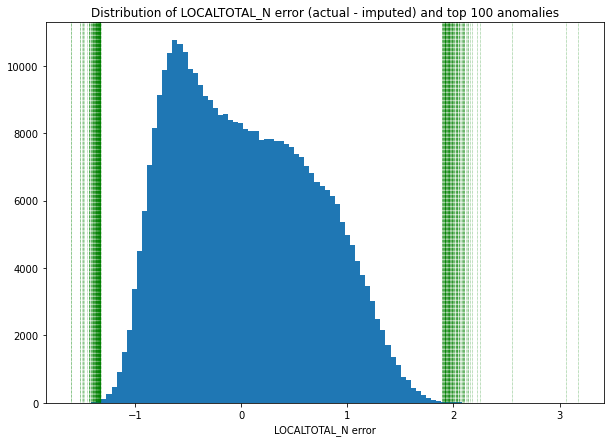

In [28]:
fig, ax = plt.subplots(figsize = (10,7))
x = W[:,10][(N[:,10] != 0) & (N[:,10] != 0)]
z = np.sort(x)
a = 100
ax.hist(x, 100);
for i in range(a):
    ax.axvline(z[i], ls = ':', lw = 0.5, color = 'g')
    ax.axvline(z[-i], ls = ':', lw = 0.5, color = 'g')
ax.set_title(f"Distribution of {df_dat.columns[10]} error (actual - imputed) and top {a} anomalies")
ax.set_xlabel(f"{df_dat.columns[10]} error")

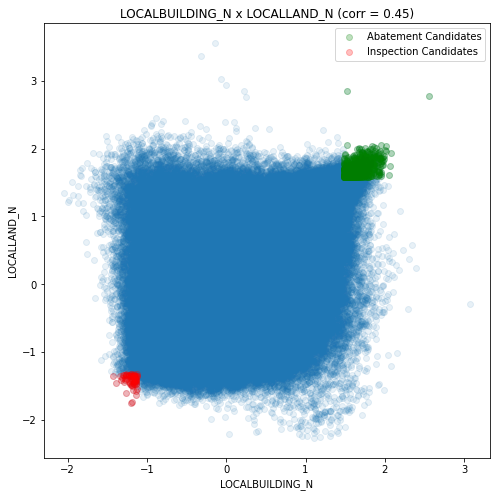

In [32]:
fig, ax = plt.subplots(figsize = (8,8))
x = W[:,8][(N[:,8] != 0) & (N[:,9] != 0)]
y = W[:,9][(N[:,8] != 0) & (N[:,9] != 0)]
r = np.corrcoef(x, y)[0,1]
A = (x > np.percentile(x, 99)) & (y > np.percentile(y, 99))
I = (x < np.percentile(x, 1)) & (y < np.percentile(y, 1))

ax.scatter(x, y, alpha = 0.1)
ax.scatter(x[A], y[A], color = 'g', 
           label = 'Abatement Candidates', alpha = 0.25)
ax.scatter(x[I], y[I], color = 'r', 
           label = 'Inspection Candidates', alpha = 0.25)
ax.set_title(f"{df_dat.columns[8]} x {df_dat.columns[9]} (corr = {r:.2f})")
#ax.set_xlim(np.percentile(x, [0.01,99.9]))
#ax.set_ylim(np.percentile(y, [0.01,99.9]))
ax.set_xlabel(f"{df_dat.columns[8]}")
ax.set_ylabel(f"{df_dat.columns[9]}")
ax.legend()

/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


(Index([], dtype='object'),
 Index(['LOTAREA_N', 'SALEPRICE_N', 'PREVSALEPRICE_N', 'PREVSALEPRICE2_N',
        'COUNTYEXEMPTBLDG_N', 'LOCALTOTAL_N', 'STORIES_N', 'YEARBLT_N',
        'TOTALROOMS_N', 'BEDROOMS_N',
        ...
        'HEATINGCOOLING_K_3', 'BSMTGARAGE_O_0', 'BSMTGARAGE_O_1',
        'BSMTGARAGE_O_2', 'BSMTGARAGE_O_3', 'BSMTGARAGE_O_4', 'BSMTGARAGE_O_5',
        'BSMTGARAGE_O_6', 'BSMTGARAGE_O_nan', 'HOMESTEADFLAG_B'],
       dtype='object', length=105))

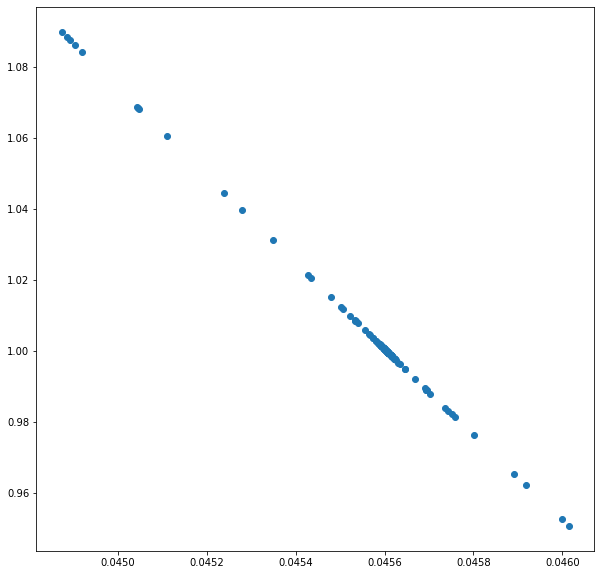

In [70]:
plt.subplots(figsize = (10, 10))
plt.scatter(sqe_Y / num_Y, (sqe_N / num_N) / (sqe_Y / num_Y))
df_dat.columns[sqe_N / num_N > 0.0495], df_dat.columns[sqe_N / num_N < 0.04785], 

In [84]:
num_N

array([1226776., 1226660., 1225045., 1225274., 1224596., 1225840.,
       1226145., 1227307., 1226126., 1227096., 6766519., 1225448.,
       1224999., 1227561., 1226655., 1224953., 1226164., 1224710.,
       1226624., 1225603., 1226889., 1226348., 1226060., 1226636.,
       1226633., 1225989., 1227468., 1226739., 1225311., 1227828.,
       1227609., 1225889., 1225572., 1227313., 1226832., 1225297.,
       1226940., 1225893., 1225928., 1226882., 1226629., 1225509.,
       1226660., 1226355., 1226890., 1226297., 1226910., 1226648.,
       1225162., 1226641., 1225828., 1225993., 1226781., 1225234.,
       1224714., 1226719., 1227170., 1227663., 1226287., 1226403.,
       1225580., 1227850., 1226706., 1225220., 1225537., 1225300.,
       1225914., 1227155., 1225094., 1224910., 1226483., 1225546.,
       1225471., 1226360., 1226565., 1225226., 1225860., 1226328.,
       1226524., 1228416., 1226857., 1228195., 1228634., 1226217.,
       1226218., 1225934., 1225690., 1227331., 1227439., 12269

In [113]:
n_in

Index(['COUNTYBUILDING_N', 'COUNTYLAND_N', 'COUNTYTOTAL_N', 'LOCALBUILDING_N',
       'LOCALLAND_N', 'FAIRMARKETBUILDING_N', 'FAIRMARKETLAND_N',
       'FAIRMARKETTOTAL_N', 'HEATINGCOOLING_K_1'],
      dtype='object')

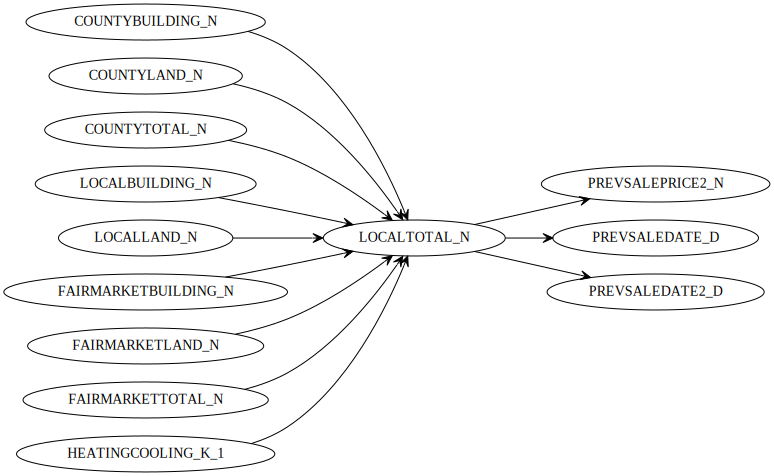

In [112]:
e = (sqe_N[num_Y != 0] / num_N[num_Y != 0])
e = (e - e.mean())/ e.std()
ll = sqe_N[num_Y != 0][e < -1.5].max()
hh = sqe_N[num_Y != 0][e >  1.5].min()
sqe_N[num_Y == 0] = float('nan')

n_in = df_dat.columns[sqe_N > hh]
n_out = df_dat.columns[sqe_N < ll]

from graphviz import Digraph

dot = Digraph(comment = 'Inputs')
dot.graph_attr['rankdir'] = 'LR'
dot.edge_attr.update(arrowhead='vee', arrowsize='1')

dot.node(f"{len(n_in) + len(n_out)}", 'LOCALTOTAL_N')
for i in range(len(n_in)):
    dot.node(f"{i}", n_in[i])
    dot.edge(f"{i}", f"{len(n_in)  + len(n_out)}")
for i in range(len(n_out)):
    dot.node(f"{i+len(n_in)}", n_out[i])
    dot.edge(f"{len(n_in) + len(n_out)}", f"{i+len(n_in)}")
#dot.unflatten(stagger=3)
dot
#n_in, n_out, labels

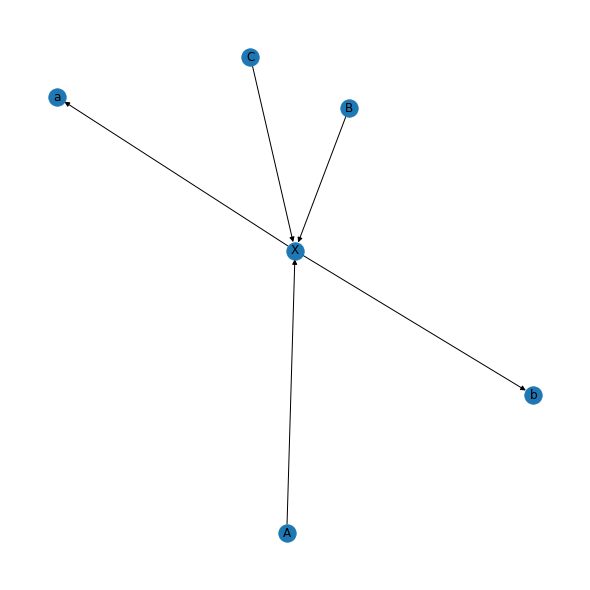

In [79]:
G = nx.MultiDiGraph()
labels = {0: 'X', 1: 'A', 2: 'B', 3: 'C', 4: 'a', 5: 'b'}
G.add_edges_from([(1,0), (2,0), (3,0), (0, 4), (0,5)])
plt.figure(figsize=(8,8))
nx.draw(G, 
        #connectionstyle='arc3, rad = 0.5',
        labels = labels, with_labels = True)

